<a href="https://colab.research.google.com/github/ParalelaUCM/biciMAD/blob/master/PracticaSpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

Instalamos y configuramos las herramientas necesarias para empezar a trabajar

In [0]:
!apt-get install openjdk-8-jdk
!apt install unzip
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark

In [0]:
!apt install unzip

# **Descargamos los datasets de bicimad**
Descargaremos cada dataset de la web oficial) de biciMAD. Los renombraremos a '.zip' para poder descomprimirlos y una vez descomprimidos los movemos a la carpeta 'datasets'. Por último eliminamos los ficheros comprimidos.

In [0]:
#Carpeta para el dataset
!mkdir dataset

In [0]:
#Enero de 2019
!wget -N "https://opendata.emtmadrid.es/getattachment/2ebcc70a-4914-43c6-9ada-a0f0520032a4/201901_Usage_Bicimad.aspx"
!mv 201901_Usage_Bicimad.aspx 201901_Usage_Bicimad.zip
!unzip 201901_Usage_Bicimad.zip
!mv 201901_Usage_Bicimad.json dataset
!rm 201901_Usage_Bicimad.zip

In [0]:
'''
#Febrero de 2019
!wget -N "https://opendata.emtmadrid.es/getattachment/aa8c34d2-ddba-46d9-b6db-882c0b4a12f0/201902_Usage_Bicimad.aspx"
!mv 201902_Usage_Bicimad.aspx 201902_Usage_Bicimad.zip 
!unzip 201902_Usage_Bicimad.zip
!mv 201902_Usage_Bicimad.json dataset
!rm 201902_Usage_Bicimad.zip
'''

In [0]:

'''
#Junio de 2019
!wget -N "https://opendata.emtmadrid.es/getattachment/7517a650-ccdf-4ab1-b1b0-a1d13694472e/201906_Usage_Bicimad.aspx"
!mv 201906_Usage_Bicimad.aspx 201906_Usage_Bicimad.zip
!unzip 201906_Usage_Bicimad.zip
!mv 201906_Usage_Bicimad.json dataset
!rm 201906_Usage_Bicimad.zip
'''

# **Ahora ya podemos empezar**

In [0]:
#Aquí ya podemos empezar a trabajar
import json
from pyspark import SparkContext
sc = SparkContext()

In [0]:
#Para usar dataFrames que puede ser interesante (No he usado nada de esto abajo)
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.json("/content/dataset/201901_Usage_Bicimad.json")
df.show()

In [0]:
rdd_raw  = sc.textFile('/content/dataset/201901_Usage_Bicimad.json')

In [132]:
rdd_raw.take(1)

['{ "_id" : { "$oid" : "5c4b07ea2f38432e007daab8" }, "user_day_code" : "b3b5b61509ab89afbf4d1e589d229bebe6637c2de819f5d612762c939b8d7f1f", "idplug_base" : 14, "track" : { "type" : "FeatureCollection", "features" : [ { "geometry" : { "type" : "Point", "coordinates" : [ -3.6803143, 40.4048615 ] }, "type" : "Feature", "properties" : { "var" : "28007,ES,Madrid,Madrid,AVDA MENENDEZ PELAYO 117,Madrid", "speed" : 1.77, "secondsfromstart" : 153 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.67770349972222, 40.4029987997222 ] }, "type" : "Feature", "properties" : { "var" : "28007,ES,Madrid,Madrid,AVDA CIUDAD DE BARCELONA 51,Madrid", "speed" : 6.58, "secondsfromstart" : 93 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.67432209972222, 40.4009430997222 ] }, "type" : "Feature", "properties" : { "var" : "28007,ES,Madrid,Madrid,AVDA CIUDAD DE BARCELONA 81,Madrid", "speed" : 4.72, "secondsfromstart" : 32 } } ] }, "user_type" : 1, "idunplug_base" : 23, "travel_time" : 162, 

In [0]:
def mapper(line):
  data = json.loads(line)
  user = data['user_type']
  user_day = data['user_day_code']
  start = data['idunplug_station']
  end = data['idplug_station']
  date = data['unplug_hourTime']['$date'][0:10]
  hora = data['unplug_hourTime']['$date'][11:19]
  time = data['travel_time']
  return user, user_day, start, end , time, date, hora 

In [0]:
def horasNocturnas(line):
  data = json.loads(line)
  hora_minima = 3600 #Esto seria pasar las 01:00:00 horas a segundos‬
  hora_maxima = 18000 #Esto seria pasar las 05:00:00 horas a segundos‬
  hora = data['unplug_hourTime']['$date'][11:19]
  hora_actual = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
  #En teoria con multipicar solo las horas ya valdria porque no hay ni minutos ni segundos
  return hora_minima <= hora_actual <= hora_maxima
rddNocturna = rdd_raw.filter(lambda x: horasNocturnas(x))

In [134]:
rddNocturna.take(1)

['{ "_id" : { "$oid" : "5c4b07eb2f38432e007dab5e" }, "user_day_code" : "19b185c5dd95c1ef7f807c94d159e980d1eb31c53f2093c33d1d7dcd54c4a7d1", "idplug_base" : 16, "user_type" : 1, "idunplug_base" : 23, "travel_time" : 318, "idunplug_station" : 102, "ageRange" : 5, "idplug_station" : 95, "unplug_hourTime" : { "$date" : "2019-01-01T01:00:00.000+0100" }, "zip_code" : "28001" }']

In [137]:
#Separamos ahora por tipo de usuario y vemos cuantos hay de cada tipo en total en todo el mes
rddNocturna_datos = rddNocturna.map(mapper)
nigth_data = rddNocturna_datos.countByKey()
nigth_data

defaultdict(int, {0: 157, 1: 13843, 2: 132, 3: 2432})

([<matplotlib.axis.XTick at 0x7ff6a139acf8>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')])

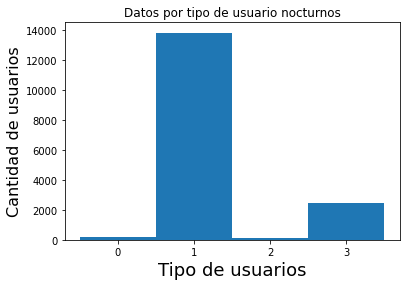

In [138]:
import matplotlib.pyplot as plt
import numpy as np
plt.title('Datos por tipo de usuario nocturnos')
names = list(nigth_data.keys())
values = list(nigth_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])

Podemos observar como la mayoria de usuarios que han usado bicimad por la noche son usuarios del tipo 1, que son los usuarios anuales mientras que hay muy pocos usuarios ocasionales. Veamos una comparacion con los datos diurnos.

In [0]:
def horasDiurnas(line):
  data = json.loads(line)
  hora_minima = 18000 #Esto seria pasar las 05:00:00 horas a segundos‬
  hora = data['unplug_hourTime']['$date'][11:19]
  hora_actual = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
  #En teoria con multipicar solo las horas ya valdria porque no hay ni minutos ni segundos
  return hora_minima < hora_actual
rddDiurna = rdd_raw.filter(lambda x: horasDiurnas(x))

In [140]:
rddDiurna.take(1)

['{ "_id" : { "$oid" : "5c4b07ef2f38432e007dae95" }, "user_day_code" : "963823d9e2087febb35ccffa49f4311dc679dede68cc5aafe7a385f24009575d", "idplug_base" : 5, "track" : { "type" : "FeatureCollection", "features" : [ { "geometry" : { "type" : "Point", "coordinates" : [ -3.6910045, 40.4080585997222 ] }, "type" : "Feature", "properties" : { "var" : "28007,ES,Madrid,Madrid,AVDA CIUDAD DE BARCELONA 2D,Madrid", "speed" : 7.27, "secondsfromstart" : 314 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.69283509972222, 40.4106409997222 ] }, "type" : "Feature", "properties" : { "var" : "28014,ES,Madrid,Madrid,PASEO PRADO 38,Madrid", "speed" : 7.5, "secondsfromstart" : 254 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.6943575, 40.4149359997222 ] }, "type" : "Feature", "properties" : { "var" : "28014,ES,Madrid,Madrid,PASEO PRADO,Madrid", "speed" : 8, "secondsfromstart" : 194 } }, { "geometry" : { "type" : "Point", "coordinates" : [ -3.69392699972222, 40.4191884997222 ] }, 

In [143]:
#Separamos ahora por tipo de usuario y vemos cuantos hay de cada tipo en total en todo el mes
rddDiurna_datos = rddDiurna.map(mapper)
day_data = rddDiurna_datos.countByKey()
day_data

defaultdict(int, {0: 1646, 1: 233460, 2: 1793, 3: 18328})

Para ver la diferencia entre los datos nocturnos y los diurnos, es necesario hacer una proporcion para ver como son estos datos

In [144]:
#Proporcion datos nocturnos
132/13843

0.00953550530954273

In [145]:
#Proporcion datos diurnos
1793/233460

0.007680116508181273

Las proporciones son muy parecidas por lo que podriamos considerar que no afecta el tipo de usuarios dependiendo de las horas